# Clausius Clapeyron (CC) scaling of extreme events
## In this lab, we will explore the future of extreme precipitation events.  
 - Recall from lecture that the moisture budget for strong events is dominated by convergence: $ P = \langle q(-D) \rangle $, where $P$ is precipitation, $q$ is specific humidity, $D$ is divergence, and $\langle\cdot\rangle$ represents the vertical average. 
 - According to the equation above, regions with high degree of convergent moist air receive more precipitation. 
 - According to the CC relation, warmer air can hold more water vapor with respect to the liquid phase. A linear approximation to the CC relation indicates that an air parcel can hold $\sim$ 7% more moisture per degree C of warming. 
 - If we assume that divergence, $D$, stays relatively constant during extreme events, what does an increase in $q$ indicate for regions of convergence and divergence? By how much should precipitation change for these regions?
 - Try to answer the questions before running the notebook to check your understanding!

In [1]:
import numpy as np
import scipy.stats
import netCDF4
from scipy import signal


import matplotlib.patches
import matplotlib.gridspec
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline

degree_sign = '\N{DEGREE SIGN}'

In [2]:
#Hack to fix missing PROJ4 env var
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
 
from mpl_toolkits import basemap

### Define a smoothing filter for easier interpretation of the maps. The smoothing function is a simple 2D boxcar (equal weights across the points) convolution. All maps are smoothed by default.

In [3]:
def smooth(x,kx,ky):
    kernel = np.ones((kx,ky))/(kx*ky)
    return scipy.signal.convolve2d(x,kernel,mode='same',boundary = 'wrap')
    

In [4]:
model_names = ['CESM2-WACCM', 
               'GFDL-CM4',
               'MPI-ESM1-2-LR',
               'MRI-ESM2'
              ]

In [5]:
################ Choose model #####################

model_index = 0

# 0 CESM2-WACCM
# 1 GFDL-CM4
# 2 MPI-ESM-2-LR
# 3 MRI-ESM2

model_name = model_names[model_index]

In [6]:
# specify whether you want to use the early or late period

late_century, early_century   = True, False # selects 2070 - 2100 
#early_century, late_century  = True, False # selects 2015 - 2045 for CMIP6 models, 2005 - 2035 for CMIP5 models


#True for landmasking, that is only include events over land
maskit = True

### Choose a percentile to define the extreme events. 

In [7]:
perc_hi = 99.9 # 99.9th percentile
perc_lo = 1 # 1st percentile

### Choose a season

In [8]:
# SEASONS

#season='DJF'; months=[12,1,2]
#season='MAM'; months=[3,4,5]
#season='JJA'; months=[6,7,8]
#season='SON'; months=[9,10,11]
season='annual'; months=[1,2,3,4,5,6,7,8,9,10,11,12]

In [9]:
file_root = '/home/datasets/aos112_2020/AOS112_Lab_2_Extreme_daily_data/cmip6/' 


hist_filename      = 'pr_day_' + model_names[model_index] + '_historical_r1i1p1_' \
                        + '19800101-20091231.nc' 

ssp_early_filename = 'pr_day_' + model_names[model_index] + '_ssp585_' + 'r1i1p1_' \
                        + '20150101-20441231.nc' 

ssp_late_filename  = 'pr_day_' + model_names[model_index] + '_ssp585_'  + 'r1i1p1_' \
                        + '20700101-20991231.nc'



#  list files to check the paths are correct 
!ls $file_root$hist_filename
!ls $file_root$ssp_early_filename
!ls $file_root$ssp_late_filename

#!ls $file_root #uncomment this line to see all model filenames

/home/datasets/aos112_2020/AOS112_Lab_2_Extreme_daily_data/cmip6/pr_day_CESM2-WACCM_historical_r1i1p1_19800101-20091231.nc
/home/datasets/aos112_2020/AOS112_Lab_2_Extreme_daily_data/cmip6/pr_day_CESM2-WACCM_ssp585_r1i1p1_20150101-20441231.nc
/home/datasets/aos112_2020/AOS112_Lab_2_Extreme_daily_data/cmip6/pr_day_CESM2-WACCM_ssp585_r1i1p1_20700101-20991231.nc


### Choose a region to analyze by uncommenting the line. You can also make your own! Note that your region must include land if the `maskit` argument is true.

In [10]:
#Example regions
#lat_lo = 30; lat_hi = 45; lon_lo = 230; lon_hi = 250; region='California'
#lat_lo = 35; lat_hi = 45; lon_lo = 255; lon_hi = 275; region='Central US'
#lat_lo = -45; lat_hi = -10.; lon_lo = 110; lon_hi = 156; region='Australia'
#lat_lo = -10; lat_hi = 10; lon_lo = -25; lon_hi = 60; region='Equatorial Africa'
#lat_lo = 40; lat_hi = 60; lon_lo = 80; lon_hi = 110; region='Central Asia'
#lat_lo = -10; lat_hi = 10; lon_lo = 160; lon_hi = 240; region='Tropical Pacific'
#lat_lo = 75; lat_hi = 90; lon_lo = 0; lon_hi = 360; region='Arctic Circle'
lat_lo = 20; lat_hi = 35; lon_lo = 100; lon_hi = 120; region='SE China'
#lat_lo = 10; lat_hi = 25; lon_lo = 40; lon_hi = 60; region = 'SW Arabian Peninsula' 
#Change this line or replace with one from above (without # sign) to change region
#lat_lo = 35; lat_hi = 45; lon_lo = 255; lon_hi = 275; region='Central US'
#lat_lo = -10; lat_hi = 10; lon_lo = -80+360; lon_hi = -40+360; region = 'Amazon'
#lat_lo = 13; lat_hi = 20; lon_lo = -30+360; lon_hi =-20+360 ; region = 'Cape Verde Islands' 
#lat_lo = 3; lat_hi = 30; lon_lo = 70; lon_hi =90 ; region = 'Southern India' 
#lat_lo = 25; lat_hi = 35; lon_lo = 0; lon_hi = 40; region='Equatorial Africa'
#lat_lo = 15; lat_hi = 25; lon_lo = 250; lon_hi = 280; region='Mexico'

#Change this line or replace with one from above (without # sign) to change region
#lat_lo = 35; lat_hi = 45; lon_lo = 255; lon_hi = 275; region='Central US'

### Open the data you selected above
- This cell takes a minute to run due to large data sets

In [11]:
# open historical
ncfile_hist = netCDF4.Dataset(file_root + hist_filename, 'r', format='NETCDF4')
time_variable_hist = ncfile_hist.variables['time']
time_variable_hist_converted = netCDF4.num2date(time_variable_hist[:], time_variable_hist.units, time_variable_hist.calendar)

# open RCP 8.5
if late_century: # if rcp_late=True, open the later time frame (2070-2100)
    ncfile_ssp = netCDF4.Dataset(file_root + ssp_late_filename, 'r', format='NETCDF4')
    ssp_years  = '2071-2100'
    hist_years = '1970-2000'
else: # otherwise, open the earlier time frame (2005-2035)
    ncfile_ssp = netCDF4.Dataset(file_root + ssp_early_filename, 'r', format='NETCDF4')
    ssp_years  = '2015-2045'
    hist_years = '1971-2000'

time_variable_ssp            = ncfile_ssp.variables['time']
time_variable_ssp_converted = netCDF4.num2date(time_variable_ssp[:], time_variable_ssp.units, \
                                               time_variable_ssp.calendar)

model_lat = ncfile_hist.variables['lat'][:]
model_lon = ncfile_hist.variables['lon'][:]


### Get latitude and longitude values where the region is located

In [12]:
reg_lon_ind =(model_lon>=lon_lo) & (model_lon<=lon_hi)
reg_lat_ind = (model_lat>=lat_lo) & (model_lat<=lat_hi)

### Define time periods to analyze

In [13]:
# historical
hist_start   = dt.datetime(1980,1,1)
hist_end     = dt.datetime(2009,12,31)


# SSP585
if late_century:
    ssp_start   = dt.datetime(2070,1,1)
    ssp_end     = dt.datetime(2099,12,31)
else:
    ssp_start = dt.datetime(2015,1,1)
    ssp_end = dt.datetime(2044,12,31)




In [14]:
time_indices_hist = np.array([(t.month in months)&(t.year in range(hist_start.year, hist_end.year+1)) 
                                 for t in time_variable_hist_converted])

time_indices_ssp  = np.array([(t.month in months)&(t.year in range(ssp_start.year, ssp_end.year+1)) 
                                for t in time_variable_ssp_converted])


model_hist_prfull = ncfile_hist.variables['pr'][time_indices_hist,:,:]*86400.
model_ssp_prfull  = ncfile_ssp.variables['pr'][time_indices_ssp,:,:]*86400



print ('time_indices and model_hist, _ssp pr data arranged')

time_indices and model_hist, _ssp pr data arranged


### Apply the landmask

In [15]:
model_hist_prfull_mask = np.copy(model_hist_prfull)
model_ssp_prfull_mask = np.copy(model_ssp_prfull)

In [16]:
mask_files = ['sftlf_fx_CESM2-WACCM_historical_r1i1p1f1_gn.nc' ,
              'sftlf_fx_GFDL-CM4_historical_r1i1p1f1_gr1.nc',
             'sftlf_fx_MPI-ESM1-2-LR_historical_r1i1p1f1_gn.nc',
              'sftlf_fx_MRI-ESM2-0_historical_r1i1p1f1_gn.nc',
              'sftlf_fx_CESM2-WACCM_historical_r1i1p1f1_gn.nc' ,
              'sftlf_fx_GFDL-CM4_historical_r1i1p1f1_gr2.nc',
             ]


if maskit and model_index < 6:
    landmask     = netCDF4.Dataset('/home/datasets/aos112_2020/AOS112_Lab_2_Extreme_daily_data/masks/' + mask_files[model_index],'r').variables['sftlf'][:] 
    # reglandmask refers to the regional landmask, so now we take the slice out of the landmask matrix defined above  
    # which corresponds to the region we selected
    for k in np.arange(len(model_hist_prfull)):
        model_hist_prfull_mask[k][landmask<100] = np.nan 
    for k in np.arange(len(model_ssp_prfull)):
        model_ssp_prfull_mask[k][landmask<100] = np.nan

model_hist_pr = model_hist_prfull_mask
model_ssp_pr = model_ssp_prfull_mask

/home/twemmen/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  # This is added back by InteractiveShellApp.init_path()


### Extract regional data

In [17]:
regmodel_ssp_pr  = model_ssp_pr[:,:,:][:,reg_lat_ind,:][:,:,reg_lon_ind]
regmodel_hist_pr = model_hist_pr[:,:,:][:,reg_lat_ind,:][:,:,reg_lon_ind]

In [18]:
Nbins=90 #100  #sets the number of bins for the histogram
#  binning range set by the maximum precip encountered times a factor slightly larger than one  e.g., 1.1 

bins = np.logspace(-1,np.log10(max(regmodel_ssp_pr[~np.isnan(regmodel_ssp_pr)].max(),regmodel_hist_pr[~np.isnan(regmodel_hist_pr)].max())*1.1),Nbins) 
# log spaced bins
#bins = np.linspace(0.1,model_rcp_pr.max(),Nbins) # linearly spaced bins
hist_histogram, bin_edges = np.histogram(regmodel_hist_pr[~np.isnan(regmodel_hist_pr)], bins=bins, density=True)
ssp_histogram, bin_edges  = np.histogram(regmodel_ssp_pr[~np.isnan(regmodel_ssp_pr)], bins=bins, density=True)

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = np.diff(bin_edges)

In [19]:

reg_wet_ssp          = regmodel_ssp_pr[regmodel_ssp_pr!=0&~np.isnan(regmodel_ssp_pr)];
reg_wet_hist         = regmodel_hist_pr[regmodel_hist_pr!=0&~np.isnan(regmodel_hist_pr)];


reg_mom_rat_ssp    = (np.nanmean(reg_wet_ssp**2)-np.nanmean(reg_wet_ssp)**2)/np.nanmean(reg_wet_ssp)**2
reg_mom_rat_hist   =  (np.nanmean(reg_wet_hist**2)-np.nanmean(reg_wet_hist)**2)/np.nanmean(reg_wet_hist)**2
# comment with moment ratios
reg_value_hi_hist  = np.nanpercentile(regmodel_hist_pr, perc_hi)
reg_value_hi_ssp   = np.nanpercentile(regmodel_ssp_pr, perc_hi)


# ==================================================
# Histograms of daily precipitation
# ==================================================

### Code to choose a lower threshold for precipitation (default:  values of 0 are included in histogram)

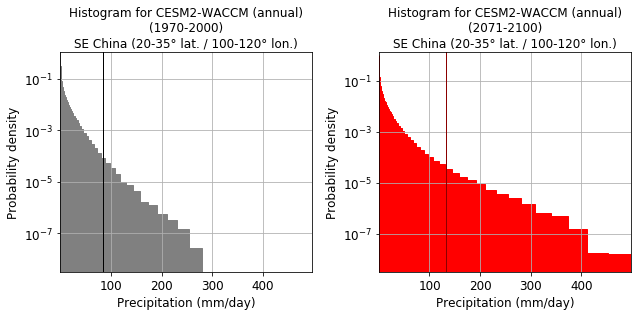

In [20]:
fig = plt.figure(figsize=(9,4.5))
fontsize=12

ax1 = fig.add_subplot(121)
ax1.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0.5', edgecolor='0.5', label='historical')
ax1.set_xlim(bins[0], bins[-1]) #sets the x-range to go from 1st bin to last bin values
ax1.set_ylim(10**-8.5, hist_histogram[0])
ax1.tick_params(labelsize=fontsize)
ax1.set_ylabel('Probability density', fontsize=fontsize)
ax1.set_xlabel('Precipitation (mm/day)', fontsize=fontsize)
ax1.set_yscale('log')
#this sets the log y-scale
#ax1.set_xscale('log')
ax1.set_title('Histogram for '+model_name+' ('+season+')'+'\n('+hist_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)

#t=ax1.text(s='{:.2f}'.format(value_hi_hist)+'mm/day\n'+str(perc_hi)+'%', ha='left', va='top', x=value_hi_hist+5, y=10**-1, fontsize=fontsize)
#t.set_bbox(dict(color='1', alpha=0.75))
#ax1.scatter(x=hist_mean, y=hist_histogram[0], s=50, marker='o', clip_on=False, color='0.5', label='hist. mean ('+'{0:.1f}'.format(hist_mean)+' mm/day)')
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', edgecolor='red', label='RCP8.5')
ax2.set_xlim(bins[0], bins[-1])
ax2.set_ylim(10**-8.5, hist_histogram[0]*1.25)
ax2.tick_params(labelsize=fontsize)
ax2.set_ylabel('Probability density', fontsize=fontsize)
ax2.set_xlabel('Precipitation (mm/day)', fontsize=fontsize)
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_title('Histogram for '+model_name+' ('+season+')'+'\n('+ssp_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)
ax2.axvline(reg_value_hi_ssp, lw=1, c='darkred')
ax1.axvline(reg_value_hi_hist, lw=1, c='0')

#ax2.axvline(reg_mom_rat_rcp, lw=1, c='darkred')
#ax1.axvline(reg_mom_rat_hist, lw=1, c='0')


#t=ax2.text(s='{:.2f}'.format(value_hi_rcp)+'mm/day\n'+str(perc_hi)+'%', ha='left', va='top', x=value_hi_rcp+5, y=10**-1, fontsize=fontsize)
#t.set_bbox(dict(color='1', alpha=0.75))
#ax2.scatter(x=rcp_mean, y=hist_histogram[0], s=50, marker='o', clip_on=False, c='red', label='RCP8.5 mean ('+'{0:.1f}'.format(rcp_mean)+' mm/day)')
ax2.grid()

fig.tight_layout()

### Overlapping histograms

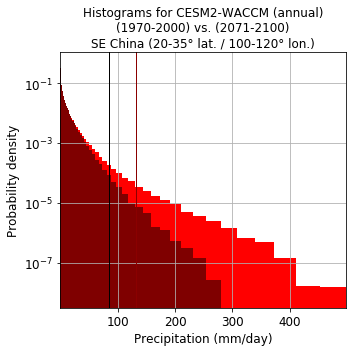

In [21]:
fig = plt.figure(figsize=(5,5))
fontsize=12

ax = fig.add_subplot(111)
ax.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0', lw=0, label='hist. ('+hist_years+')', zorder=1, alpha=0.5)
ax.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', lw=0, label='SSp585 ('+ssp_years+')', zorder=0)
ax.set_xlim(bins[0], bins[-1])   #sets the x-range to go from 1st bin to last bin values
ax.set_ylim(10**-8.5, hist_histogram[0])
ax.set_ylabel('Probability density', fontsize=fontsize)
ax.set_xlabel('Precipitation (mm/day)', fontsize=fontsize)
ax.set_title('Histograms for '+model_name+' ('+season+')'+'\n('+hist_years+') vs. ('+ssp_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)

ax.axvline(reg_value_hi_hist, lw=1, c='0')
ax.axvline(reg_value_hi_ssp, lw=1, c='darkred')

ax.set_yscale('log') # use log scale
ax.tick_params(labelsize=fontsize)
#ax.set_xscale('log')
handles, labels = ax.get_legend_handles_labels()
#t=ax.text(s='{:.2f}'.format(regvalue_hi_rcp)+'mm/day\n'+str(perc_hi)+'%', ha='left', va='top', x=value_hi_rcp+5, y=10**-1, fontsize=fontsize)


ax.grid()
fig.tight_layout()

### Overlapping histograms on  log-log scale.

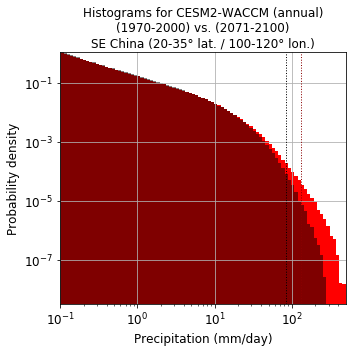

In [34]:
fig = plt.figure(figsize=(5,5))
fontsize=12

ax = fig.add_subplot(111)
ax.bar(bin_centers, hist_histogram, align='center', width=bin_width, color='0', lw=0, label='hist. ('+hist_years+')', zorder=1, alpha=0.5)
ax.bar(bin_centers, ssp_histogram, align='center', width=bin_width, color='red', lw=0, label='SSP585 ('+ssp_years+')', zorder=0)
# Uncomment two lines below and comment two lines above for outline of histogram
#ax.plot(bin_centers, hist_histogram,color='black')# align='center', width=bin_width, color='0', lw=0, label='hist. ('+hist_years+')', zorder=1, alpha=0.5)
#ax.plot(bin_centers, ssp_histogram,color='red')# align='center', width=bin_width, color='red', lw=0, label='RCP8.5 ('+rcp_years+')', zorder=0)

ax.set_xlim(bins[0], bins[-1])   #sets the x-range to go from 1st bin to last bin values
ax.set_ylim(10**-8.5, hist_histogram[0])
ax.set_ylabel('Probability density', fontsize=fontsize)
ax.set_xlabel('Precipitation (mm/day)', fontsize=fontsize)
ax.set_title('Histograms for '+model_name+' ('+season+')'+'\n('+hist_years+') vs. ('+ssp_years+')\n'+region+' ('+str(lat_lo)+'-'+str(lat_hi)+degree_sign+' lat. / '+str(lon_lo)+'-'+str(lon_hi)+degree_sign+' lon.)', fontsize=fontsize)
ax.set_xscale('log')
#ax.axvline(regmomrat_hist, lw=1, c='0')
#ax.axvline(regmomrat_rcp, lw=1, c='darkred')
ax.axvline(reg_value_hi_ssp, lw=1, c='darkred',ls=':')
ax.axvline(reg_value_hi_hist, lw=1, c='0',ls=':')

#ax.axvline(reg_mom_rat_ssp, lw=1, c='darkred')
#ax.axvline(reg_mom_rat_hist, lw=1, c='0')


ax.set_yscale('log') # use log scale
ax.tick_params(labelsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::-1], labels[::-1], loc=0, fontsize=fontsize)

ax.grid()
fig.tight_layout()


In [32]:
print(str(np.round(reg_value_hi_hist,2))+' mm/day'+' is the '+str(perc_hi)+'th percentile for historical')
print(str(np.round(reg_value_hi_ssp,2))+' mm/day'+' is the '+str(perc_hi)+'th percentile for SSP585')
print()



84.57 mm/day is the 99.9th percentile for historical
132.47 mm/day is the 99.9th percentile for SSP585



# ==================================================
# Maps of daily precipitation extremes
# ==================================================

### Code to choose take statistics of daily precipitation for each point
- May take awhile

In [23]:
events_hist = np.copy(model_hist_prfull)
events_ssp  = np.copy(model_ssp_prfull)

events_hist[events_hist==0] = np.nan
events_ssp[events_ssp==0]   = np.nan 


mom1_hist = np.mean(events_hist,0)
mom2_hist = np.mean(events_hist, axis = 0)#scipy.stats.moment(wethist,moment = 2)
mom1_ssp =  np.mean(events_ssp, axis = 0)
mom2_ssp =  np.var(events_ssp, axis = 0)#scipy.stats.moment(wetrcp,moment = 2)
mom_rat_ssp = (np.mean(events_ssp**2, axis = 0)-np.mean(events_ssp, axis = 0)**2)/(np.mean(events_ssp, axis = 0))
mom_rat_hist = (np.mean(events_hist**2, axis = 0)-np.mean(events_hist, axis = 0)**2)/(np.mean(events_hist,axis = 0))
#mom2_histl[i,j] = np.var(eventsl)
value_hi_hist = np.nanpercentile(events_hist, perc_hi, axis=0)
#deventsl = np.abs(np.sort(eventsl) - value_hi_histe[i,j])
#value_hi_histl[i,j] = 100- perc_hi + 100 - (np.argmin(deventsl)/len(deventsl)*100)
value_hi_ssp = np.nanpercentile(events_ssp, perc_hi, axis=0)



dvalue_hi = value_hi_ssp - value_hi_hist
dperc = dvalue_hi/value_hi_hist*100


### Dimensions of boxcar used for smoothing are defined below

In [24]:
#define boxcar dims for smoothing
lat_box = 9  # default 9
lon_box = 11 # default 11
bx = np.argmin(np.abs(np.cumsum(np.diff(model_lat))-lat_box))+1
by = np.argmin(np.abs(np.cumsum(np.diff(model_lon))-lon_box))+1


### Historical map 

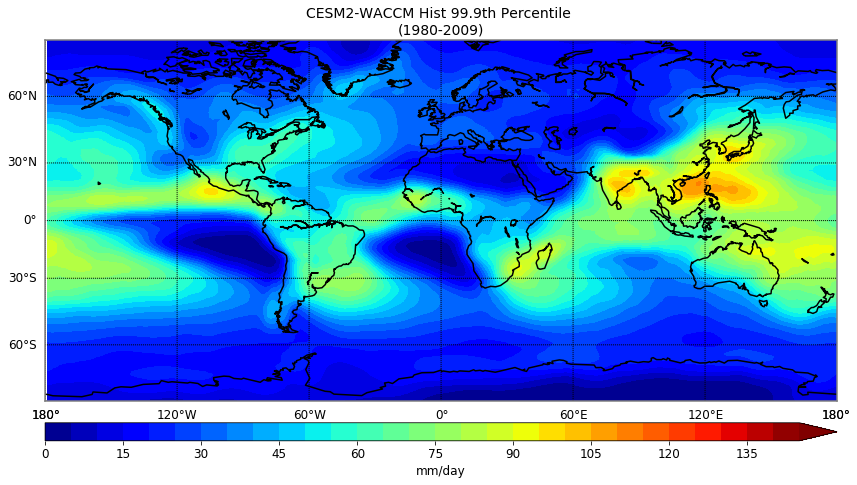

In [25]:
fig = plt.figure(figsize=(12,9))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='gall',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')

model_lon_shift, value_hi_hist_shift = map.shiftdata(model_lon, datain = value_hi_hist, lon_0=0)
lons,lats = np.meshgrid(model_lon_shift, model_lat)

value_hi_hist_shift = smooth(value_hi_hist_shift,bx,by)

parallels = np.arange(-60.,61.,30.)
meridians = np.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
xi,yi = map(lons, lats)
contour_levels = np.arange(0,150,5)
perc_map = map.contourf(xi,yi,value_hi_hist_shift,cmap='jet', levels=contour_levels, extend='max')
cbar = map.colorbar(perc_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('mm/day', fontsize=12)
ax.set_title(model_name+' Hist '+str(perc_hi)+'th Percentile \n' + '('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=14)


fig.tight_layout()

### SSP585 map 

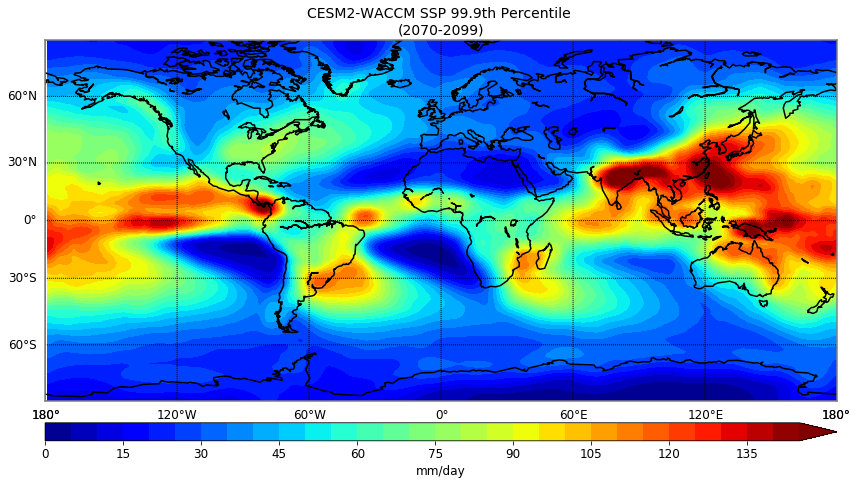

In [26]:
fig = plt.figure(figsize=(12,9))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='gall',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')

model_lon_shift, value_hi_ssp_shift = map.shiftdata(model_lon, datain = value_hi_ssp, lon_0=0)

lons,lats = np.meshgrid(model_lon_shift, model_lat)

value_hi_ssp_shift = smooth(value_hi_ssp_shift,bx,by)

parallels = np.arange(-60.,61.,30.)
meridians = np.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)
xi,yi = map(lons, lats)
contour_levels = np.arange(0,150,5)
perc_map = map.contourf(xi,yi,value_hi_ssp_shift,cmap='jet', levels=contour_levels, extend='max')
cbar = map.colorbar(perc_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('mm/day', fontsize=12)
ax.set_title(model_name+' '+'SSP '+str(perc_hi)+'th Percentile \n' + '('+str(ssp_start.year)+'-'+str(ssp_end.year)+')', fontsize=14)


fig.tight_layout()

# Scaling Maps
- below we will plot the differences, in terms of absolute and relative change per degree

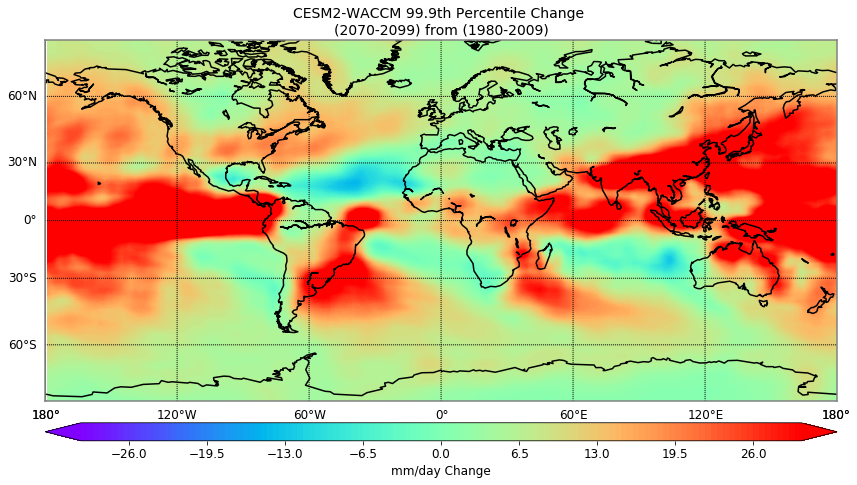

In [27]:
fig = plt.figure(figsize=(12,7))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='gall',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = np.arange(-60.,61.,30.)
meridians = np.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)



model_lon_shift, dvalue_hi_shift = map.shiftdata(model_lon, datain = dvalue_hi, lon_0=0)
lons,lats = np.meshgrid(model_lon_shift, model_lat)

dvalue_hi_shift = smooth(dvalue_hi_shift,bx,by)


xi,yi = map(lons, lats)
contour_levels = np.arange(-30,30.5,.5)
#perc_map = map.contourf(xi,yi,dperc,cmap='jet', levels=contour_levels, extend='both')
perc_map = map.contourf(xi,yi,dvalue_hi_shift,cmap='rainbow', levels=contour_levels, extend='both')
cbar = map.colorbar(perc_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('mm/day Change', fontsize=12)
ax.set_title(model_name+' '+str(perc_hi)+'th Percentile Change \n' +\
             '('+str(ssp_start.year)+'-'+str(ssp_end.year)+') from ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=14)


fig.tight_layout()

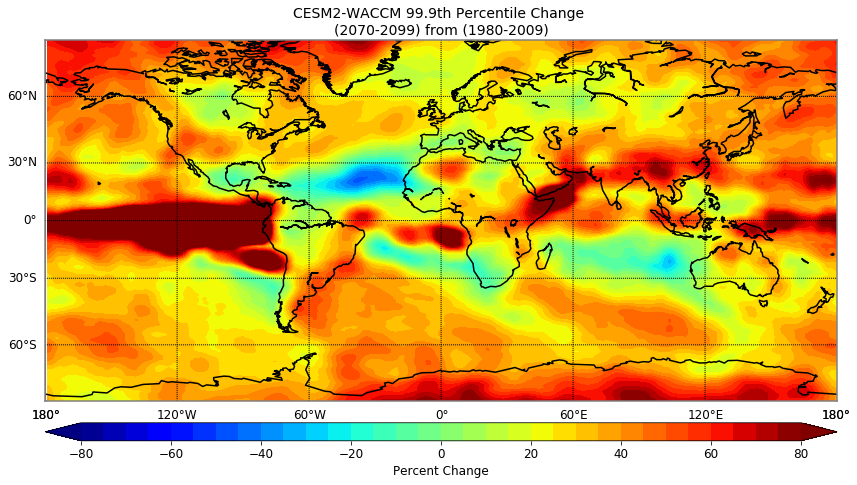

In [28]:
fig = plt.figure(figsize=(12,7))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='gall',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = np.arange(-60.,61.,30.)
meridians = np.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)



model_lon_shift, dperc_shift = map.shiftdata(model_lon, datain = dperc, lon_0=0)
lons,lats = np.meshgrid(model_lon_shift, model_lat)

dperc_shift = smooth(dperc_shift,bx,by)


xi,yi = map(lons, lats)
contour_levels = np.arange(-80,85,5)
#perc_map = map.contourf(xi,yi,dperc,cmap='jet', levels=contour_levels, extend='both')
perc_map = map.contourf(xi,yi,dperc_shift,cmap='jet', levels=contour_levels, extend='both')
cbar = map.colorbar(perc_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Percent Change', fontsize=12)
ax.set_title(model_name+' '+str(perc_hi)+'th Percentile Change \n' +\
             '('+str(ssp_start.year)+'-'+str(ssp_end.year)+') from ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=14)


fig.tight_layout()

### In cell below we have values of average temperature change for the globe and the tropics. We will use the values to find the change in precipitation extremes per degree.

In [29]:

if late_century:
    global_dt = [5.43, 4.18, 3.45, 4.31]
    tropical_dt =  [4.28, 3.38, 2.70, 3.16]
else:
    global_dt = [1.39,1.57,0.83,1.52]
    tropical_dt = [1.16,1.32,0.61,0.89]

    
# 0 CESM2-WACCM
# 1 GFDL-CM4
# 2 MPI-ESM-2-LR
# 3 MRI-ESM2

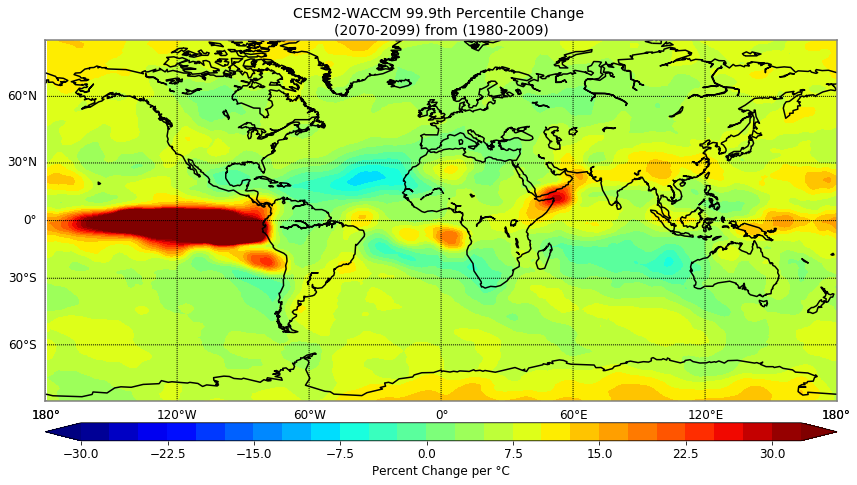

In [30]:
fig = plt.figure(figsize=(12,7))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='gall',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
map.drawcoastlines(linewidth=1.5, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1.5, color='0.5')
parallels = np.arange(-60.,61.,30.)
meridians = np.arange(0.,361.,60.)
map.drawparallels(parallels, labels=[1,0,1,0], fontsize=12)
map.drawmeridians(meridians, labels=[0,1,0,1], fontsize=12)



model_lon_shift, dperc_shift = map.shiftdata(model_lon, datain = dperc, lon_0=0)
lons,lats = np.meshgrid(model_lon_shift, model_lat)

dperc_shift = smooth(dperc_shift,bx,by)


xi,yi = map(lons, lats)
contour_levels = np.arange(-30,35,2.5)
#perc_map = map.contourf(xi,yi,dperc,cmap='jet', levels=contour_levels, extend='both')
perc_map = map.contourf(xi,yi,dperc_shift/global_dt[model_index],cmap='jet', levels=contour_levels, extend='both')
cbar = map.colorbar(perc_map, location='bottom', pad=0.3)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Percent Change per '+ degree_sign + 'C', fontsize=12)
ax.set_title(model_name+' '+str(perc_hi)+'th Percentile Change \n' +\
             '('+str(ssp_start.year)+'-'+str(ssp_end.year)+') from ('+str(hist_start.year)+'-'+str(hist_end.year)+')', fontsize=14)


fig.tight_layout()

### What regions seems to scale according to the CC relation? Above? Below? Are these results what you expected?